In [2]:

using DelimitedFiles
#using LightGraphs
using LinearAlgebra 
using PyPlot
using Random
#using BenchmarkTools
using Distributions
using StatsBase
using  OrdinaryDiffEq ###DifferentialEquations
using DiffEqCallbacks

In [3]:

N=100000;
#Random.seed!(123)
d=Cauchy()
omega=rand(d,N);
omega=omega-ones(N)*mean(omega)
v=rand(d,N);
v=v-ones(N)*mean(v);

In [4]:


function kuramoto(du, u, pp, t)

       u1 = @view u[1:N]
       du1 = @view du[1:N]
       u2 = @view u[N+1:2*N]
       du2 = @view du[N+1:2*N]

       
       j1,j2,k1,k2=pp

        z11 = Array{Complex{Float64},1}(undef, 1)
        z11= mean(exp.((u1+u2)*1im))
        z11c=conj(z11)
         
        z12 = Array{Complex{Float64},1}(undef, 1)
        z12= mean(exp.((u1-u2)*1im))
        z12c=conj(z12)
   
        z21 = Array{Complex{Float64},1}(undef, 1)
        z21= mean(exp.((u1+u2)*2im))

        z22 = Array{Complex{Float64},1}(undef, 1)
        z22= mean(exp.((u1-u2)*2im))
        

        ####### equ of motion\n",
        @. du1  = v + j1/2 * ( ( imag(z11*exp((-1im)*(u1+u2)) ))+( imag(z12*exp((-1im)*(u1-u2)) )) ) + j2/2*( ( imag(z21 * z11c * exp((-1im) * (u1+u2)) )) 
        + ( imag(z22 * z12c * exp((-1im) * (u1-u2)) )))
        @. du2 =  omega + k1/2 * ( ( imag(z11*exp((-1im)*(u1+u2)) ))-( imag(z12*exp((-1im)*(u1-u2)) )) ) + k2/2*( ( imag(z21 * z11c * exp((-1im) * (u1+u2)) )) 
        - ( imag(z22 * z12c * exp((-1im) * (u1-u2)) )))
       end;

In [5]:

# setting up time steps and integration intervals

dt = 0.01 # time step
dts = 0.1 # save time
ti = 0.0
tt = 150
tf = 200
nt = Int(div(tt,dts))
nf = Int(div(tf,dts))

tspan = (ti, tf); # time interval

u0=[-pi*ones(N)+rand(N)*2*pi;-pi*ones(N)+rand(N)*2*pi];
#du = similar(u0);

In [6]:

k1 = collect(3:0.1:12)
j1= 1
k2= 9
j2= 5


sp_fwd = zeros(size(k1)[1])
sp_bwd = zeros(size(k1)[1])
sm_fwd = zeros(size(k1)[1])
sm_bwd = zeros(size(k1)[1])

sp2_fwd = zeros(size(k1)[1])
sp2_bwd = zeros(size(k1)[1])
sm2_fwd = zeros(size(k1)[1])
sm2_bwd = zeros(size(k1)[1])



println("#####################")
println("Forward transition!")
println("#####################")

for l in 1:size(k1)[1]
  @time begin 
  print("λ=")
    println(k1[l])
    # defining problem for ODE solver
    prob = ODEProblem(kuramoto, u0, tspan, (j1,j2,k1[l],k2))

    
        saved_values1= SavedValues(Float64, Float64)
       function saver1(u,t,integrator)
          _re1=mean(cos.(u[1:N]+u[N+1:2*N]))
          _im1=mean(sin.(u[1:N]+u[N+1:2*N]))
          out1=sqrt(_re1^2 + _im1^2)
       end
     cb1 = SavingCallback(saver1, saved_values1,saveat=tt:dts:tf)

      saved_values2= SavedValues(Float64, Float64)
       function saver2(u,t,integrator)
          _re2=mean(cos.(u[1:N]-u[N+1:2*N]))
          _im2=mean(sin.(u[1:N]-u[N+1:2*N]))
          out2=sqrt(_re2^2 + _im2^2)
       end
     cb2 = SavingCallback(saver2, saved_values2,saveat=tt:dts:tf)

     saved_values3= SavedValues(Float64, Float64)
     function saver3(u,t,integrator)
        _re3=mean(cos.(2*(u[1:N]+u[N+1:2*N])))
        _im3=mean(sin.(2*(u[1:N]+u[N+1:2*N])))
        out3=sqrt(_re3^2 + _im3^2)
     end
   cb3 = SavingCallback(saver3, saved_values3,saveat=tt:dts:tf)

    saved_values4= SavedValues(Float64, Float64)
     function saver4(u,t,integrator)
        _re4=mean(cos.(2*(u[1:N]-u[N+1:2*N])))
        _im4=mean(sin.(2*(u[1:N]-u[N+1:2*N])))
        out4=sqrt(_re4^2 + _im4^2)
     end
   cb4 = SavingCallback(saver4, saved_values4,saveat=tt:dts:tf)
     
      cbs = CallbackSet(cb1, cb2, cb3, cb4)

    sol = solve(prob, Tsit5(),progress=true,callback = cbs,save_everystep=false);

    
     sp_fwd[l]= mean(saved_values1.saveval);
     sm_fwd[l]= mean(saved_values2.saveval);
     sp2_fwd[l]= mean(saved_values3.saveval);
     sm2_fwd[l]= mean(saved_values4.saveval);


    x0 = -pi*ones(N)+mod2pi.(sol[1:N,end])
    y0 = -pi*ones(N)+mod2pi.(sol[N+1:2*N,end])
    u0=[x0;y0]

    println((sp_fwd[l],sm_fwd[l],sp2_fwd[l],sm2_fwd[l]))
      end
    end;


println("#####################")
println("Backward transition!")
println("#####################")

for l in size(k1)[1]:-1:1
  @time begin
    print("λ=")
    println(k1[l])
    # defining problem for ODE solver
    prob = ODEProblem(kuramoto, u0, tspan, (j1,j2,k1[l],k2))

    
      
    saved_values1= SavedValues(Float64, Float64)
    function saver1(u,t,integrator)
       _re1=mean(cos.(u[1:N]+u[N+1:2*N]))
       _im1=mean(sin.(u[1:N]+u[N+1:2*N]))
       out1=sqrt(_re1^2 + _im1^2)
    end
  cb1 = SavingCallback(saver1, saved_values1,saveat=tt:dts:tf)

   saved_values2= SavedValues(Float64, Float64)
    function saver2(u,t,integrator)
       _re2=mean(cos.(u[1:N]-u[N+1:2*N]))
       _im2=mean(sin.(u[1:N]-u[N+1:2*N]))
       out2=sqrt(_re2^2 + _im2^2)
    end
  cb2 = SavingCallback(saver2, saved_values2,saveat=tt:dts:tf)

  saved_values3= SavedValues(Float64, Float64)
  function saver3(u,t,integrator)
     _re3=mean(cos.(2*(u[1:N]+u[N+1:2*N])))
     _im3=mean(sin.(2*(u[1:N]+u[N+1:2*N])))
     out3=sqrt(_re3^2 + _im3^2)
  end
cb3 = SavingCallback(saver3, saved_values3,saveat=tt:dts:tf)

 saved_values4= SavedValues(Float64, Float64)
  function saver4(u,t,integrator)
     _re4=mean(cos.(2*(u[1:N]-u[N+1:2*N])))
     _im4=mean(sin.(2*(u[1:N]-u[N+1:2*N])))
     out4=sqrt(_re4^2 + _im4^2)
  end
cb4 = SavingCallback(saver4, saved_values4,saveat=tt:dts:tf)
  
   cbs = CallbackSet(cb1, cb2, cb3, cb4)

 sol = solve(prob, Tsit5(),progress=true,callback = cbs,save_everystep=false);

 
  sp_bwd[l]= mean(saved_values1.saveval);
  sm_bwd[l]= mean(saved_values2.saveval);
  sp2_bwd[l]= mean(saved_values3.saveval);
  sm2_bwd[l]= mean(saved_values4.saveval);     

      x0 = -pi*ones(N)+mod2pi.(sol[1:N,end])
      y0 = -pi*ones(N)+mod2pi.(sol[N+1:2*N,end])
    u0=[x0;y0]  

  println((sp_bwd[l],sm_bwd[l],sp2_bwd[l],sm2_bwd[l]))
      end
    end;

#####################
Forward transition!
#####################
λ=3.0
(0.004142186651073102, 0.004445400246019038, 0.002708822132587002, 0.002546298044554788)
117.101086 seconds (15.23 M allocations: 55.856 GiB, 3.39% gc time, 4.97% compilation time: 1% of which was recompilation)
λ=3.1
(0.004333771735496146, 0.004359551532315572, 0.002920296536582175, 0.002906481439536305)
102.183194 seconds (470.51 k allocations: 52.008 GiB, 3.11% gc time)
λ=3.2
(0.0041838760873566215, 0.0043903706634656, 0.0029971306835622547, 0.002911639557397136)
103.858407 seconds (475.27 k allocations: 52.455 GiB, 3.23% gc time)
λ=3.3
(0.0037346337550565926, 0.004858077446661178, 0.0028539272560450285, 0.0025836830617456453)
102.030113 seconds (476.05 k allocations: 52.545 GiB, 3.08% gc time)
λ=3.4
(0.004151865916284973, 0.004312284847866849, 0.002916767238084174, 0.0027286504193854088)
118.429913 seconds (555.52 k allocations: 60.242 GiB, 2.91% gc time)
λ=3.5
(0.004304029273856699, 0.004398786902378399, 0.00289

(0.7048742207881226, 0.006381019301153026, 0.4961001697148696, 0.002714520020231358)
2274.480813 seconds (10.82 M allocations: 1.030 TiB, 2.75% gc time)
λ=8.1
(0.7087369256468575, 0.005002287889200758, 0.501666296787174, 0.002636377535999979)
2113.164758 seconds (10.07 M allocations: 982.129 GiB, 2.78% gc time)
λ=8.2
(0.7124897302036988, 0.005316839571633283, 0.507077773459177, 0.002811060834090233)
2207.343076 seconds (10.53 M allocations: 1.003 TiB, 2.76% gc time)
λ=8.3
(0.7161771592257816, 0.006554305228838371, 0.5121568551615934, 0.002830884546057649)
2320.913814 seconds (11.09 M allocations: 1.055 TiB, 2.69% gc time)
λ=8.4
(0.7196287033067809, 0.006887150813868079, 0.5172063894546349, 0.002907787094777808)
2210.630479 seconds (10.45 M allocations: 1018.467 GiB, 2.77% gc time)
λ=8.5
(0.7229725712601155, 0.005399876754505386, 0.5220403275547774, 0.002816826802434601)
2026.284773 seconds (9.67 M allocations: 943.374 GiB, 2.81% gc time)
λ=8.6
(0.7263069795150006, 0.007015512788779521,

λ=11.0
(0.7808640214780679, 0.007916308578600073, 0.6095708308404467, 0.0029201385057739627)
2375.415611 seconds (11.40 M allocations: 1.085 TiB, 2.68% gc time)
λ=10.9
(0.7791707770326094, 0.008734316130016677, 0.6069406415754226, 0.0027581569973149306)
2974.261483 seconds (14.32 M allocations: 1.361 TiB, 2.66% gc time)
λ=10.8
(0.7774828021067025, 0.007129820466880913, 0.6042344351756557, 0.0030297042989628135)
2137.602166 seconds (10.33 M allocations: 1006.921 GiB, 2.67% gc time)
λ=10.7
(0.7757104965662612, 0.009642481288022711, 0.6015634086069145, 0.002835410027350423)
2814.419082 seconds (13.56 M allocations: 1.289 TiB, 2.68% gc time)
λ=10.6
(0.7738996257046482, 0.00798623244349619, 0.5986603980400936, 0.002786061816907662)
2354.898359 seconds (11.26 M allocations: 1.071 TiB, 2.69% gc time)
λ=10.5
(0.7721083777229344, 0.009336719728487989, 0.5958675819158443, 0.002719924975012196)
3020.947676 seconds (14.51 M allocations: 1.379 TiB, 2.75% gc time)
λ=10.4
(0.7702523528943018, 0.00730

(0.007513867251622144, 0.006703845489086121, 0.0029400473689474758, 0.002813700208467533)
170.230129 seconds (799.45 k allocations: 83.871 GiB, 2.56% gc time)
λ=5.7
(0.007149326047847215, 0.007340227625233683, 0.0028599582888424032, 0.0028566341431697268)
162.492553 seconds (760.63 k allocations: 80.112 GiB, 2.54% gc time)
λ=5.6
(0.009139353698175971, 0.00758323226887606, 0.0029630300096290998, 0.002834385860428405)
192.154162 seconds (899.25 k allocations: 93.538 GiB, 2.67% gc time)
λ=5.5
(0.0057897710732079, 0.005588248263976002, 0.0026777554763360387, 0.002923544835122252)
151.119258 seconds (711.79 k allocations: 75.368 GiB, 2.60% gc time)
λ=5.4
(0.006039130660938111, 0.006373104704829268, 0.0029265993213573806, 0.0029217975095192717)
172.897900 seconds (807.77 k allocations: 84.677 GiB, 2.70% gc time)
λ=5.3
(0.006731104670177936, 0.007173983774610922, 0.0028381269172159294, 0.002913153041460731)
197.500511 seconds (922.34 k allocations: 95.775 GiB, 2.66% gc time)
λ=5.2
(0.00658333

In [7]:

########## arranging order parameter 
sp_fwd_final=zeros(size(k1)[1],1)
sm_fwd_final=zeros(size(k1)[1],1)
sp_bwd_final=zeros(size(k1)[1],1)
sm_bwd_final=zeros(size(k1)[1],1)

sp2_fwd_final=zeros(size(k1)[1],1)
sm2_fwd_final=zeros(size(k1)[1],1)
sp2_bwd_final=zeros(size(k1)[1],1)
sm2_bwd_final=zeros(size(k1)[1],1)



for jj in 1:size(k1)[1]
  sp_fwd_final[jj]=max(sp_fwd[jj],sm_fwd[jj])
  sm_fwd_final[jj]=min(sp_fwd[jj],sm_fwd[jj])
  sp_bwd_final[jj]=max(sp_bwd[jj],sm_bwd[jj])
  sm_bwd_final[jj]=min(sp_bwd[jj],sm_bwd[jj])

  sp2_fwd_final[jj]=max(sp2_fwd[jj],sm2_fwd[jj])
  sm2_fwd_final[jj]=min(sp2_fwd[jj],sm2_fwd[jj])
  sp2_bwd_final[jj]=max(sp2_bwd[jj],sm2_bwd[jj])
  sm2_bwd_final[jj]=min(sp2_bwd[jj],sm2_bwd[jj])
end

pppp=[k1 sp_fwd_final sm_fwd_final sp_bwd_final sm_bwd_final sp2_fwd_final sm2_fwd_final sp2_bwd_final sm2_bwd_final]
writedlm("2_async_to_phase_hoi_swarm_N=$N,j1=$j1,j2=$j2,k2=$k2",pppp)

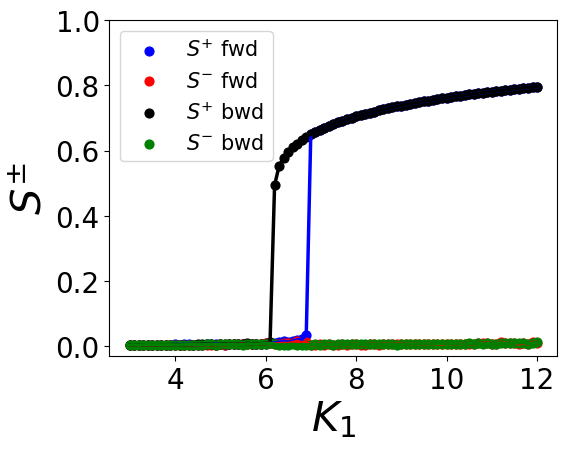

In [8]:

clf()
figsize=(9,6)
plot(k1,sp_fwd_final,c="blue",linewidth=2.5)
scatter(k1,sp_fwd_final,c="blue",s=40,label=L"$S^{+}$ fwd")
plot(k1,sm_fwd_final,c="red",linewidth=2.5)
scatter(k1,sm_fwd_final,c="red",s=40,label=L"$S^{-}$ fwd")
plot(k1,sp_bwd_final,c="black",linewidth=2.5)
scatter(k1,sp_bwd_final,c="black",s=40,label=L"$S^{+}$ bwd")
plot(k1,sm_bwd_final,c="green",linewidth=2.5)
scatter(k1,sm_bwd_final,c="green",s=40,label=L"$S^{-}$ bwd")
xlabel(L"$K_1$",fontsize=30)
ylabel(L"$S^{\pm}$",fontsize=30)
ylim(-0.03,1)
#title("N=$N,j1=$j1,k1,j2=$j2,k2=$k2")
#legend(["sp_fwd_final","", "sm_fwd_final","","sp_bwd_final","","sm_bwd_final"])
legend(fontsize=15)
xticks(fontsize=20)
yticks(fontsize=20)
rc("axes",linewidth=2)
subplots_adjust(left=0.2,right=0.9,bottom=0.2,top=0.9)
#gcf()

savefig("./N=$N,j1=$j1,j2=$j2,k2=$k2.png", dpi = 600, format = "png", transparent = false)

# verify with theoretical

In [9]:
Δ=2

2

In [10]:
sp_stable = zeros(size(k1)[1])    #Array{Complex{Float64},1}(undef, size(k1)[1])
sp_unstable =zeros(size(k1)[1]); ## Array{Complex{Float64},1}(undef, size(k1)[1]);

In [11]:
for l in 1:size(k1)[1]
    
  #  println(k1[l]);
    
    j21=(j2+k2)/2
    j11=(j1+k1[l])/2
    
    exp1=√Complex(((j21-j11) + √Complex((j21+j11)^2-8*Δ*j21))/(2*j21))
    exp2=√Complex(((j21-j11) - √Complex((j21+j11)^2-8*Δ*j21))/(2*j21))
    
    if isreal(exp1)

    exp1=exp1
    else
    exp1=NaN
    end
    
    if isreal(exp2)

    exp2=exp2
    else
    exp2=NaN
    end
    
    sp_stable[l]=exp1
    sp_unstable[l]=exp2
    
end;

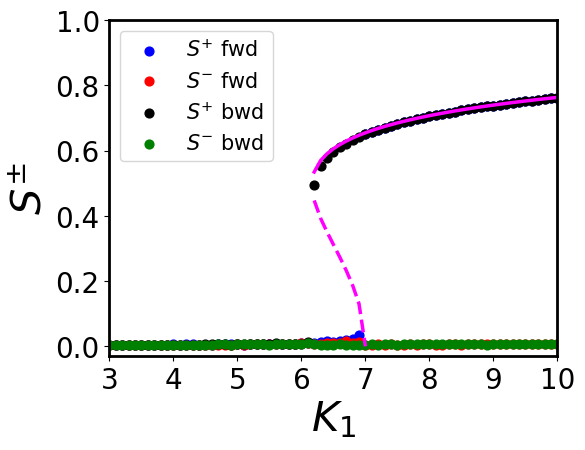

In [15]:

clf()
figsize=(9,6)
plot(k1,sp_stable,c="magenta",linewidth=2.5)
plot(k1,sp_unstable,c="magenta",linewidth=2.5,linestyle="--")
scatter(k1,sp_fwd_final,c="blue",s=40,label=L"$S^{+}$ fwd")
scatter(k1,sm_fwd_final,c="red",s=40,label=L"$S^{-}$ fwd")
scatter(k1,sp_bwd_final,c="black",s=40,label=L"$S^{+}$ bwd")
scatter(k1,sm_bwd_final,c="green",s=40,label=L"$S^{-}$ bwd")
xlabel(L"$K_1$",fontsize=30)
ylabel(L"$S^{\pm}$",fontsize=30)
ylim(-0.03,1)
xlim(3,10)
#title("N=$N,j1=$j1,k1,j2=$j2,k2=$k2")
#legend(["sp_fwd_final","", "sm_fwd_final","","sp_bwd_final","","sm_bwd_final"])
legend(fontsize=15)
xticks(fontsize=20)
yticks(fontsize=20)
rc("axes",linewidth=2)
subplots_adjust(left=0.2,right=0.9,bottom=0.2,top=0.9)
savefig("./2_numerical_theoretical_N=$N,j1=$j1,j2=$j2,k2=$k2.png", dpi = 600, format = "png", transparent = false)